# Table of Contents

This notebook provides a detailed overview of my methodology and thought process, covering data cleaning, exploratory data analysis, clustering, insights derived, and their business implications.
1. [Data Cleaning](#1.-data-cleaning)
    
    - [Preliminary Exploration](##1.2.-preliminary-exploration)
    - [Handling Data Types](##1.3.-handling-data-types)
    - [Handling Duplicates](##1.4.-handling-duplicates)
    - [Handling Null Values](##1.5.-handling-null-values)
    - [Currency Standardization](##1.6.-currency-standardization)
    - [Adding an Age Column](##1.7.-adding-an-age-column)

2. [Exploratory Data Analysis](#2.-exploratory-data-analysis-(eda))
    - [Descriptive Statistics of Numeric Variables](##2.1.-descriptive-statistics-of-numeric-variables)
    - [Univariate Analysis](##2.2.-univariate-analysis)
    - [Multivariate and Bivariate Analyses](##2.3.-multivariate-and-bivariate-analyses)

3. [Clustering with K Protorypes](#3.-clustering-with-k-prototypes)
    - [Overview](##3.1.-overview)
    - [Data Preparation](##3.2.-data-preparation)
    - [Method for Selecting the Optimal Number of Clusters (K) and Evaluating Clustering Performance](##3.3.-method-for-selecting-the-optimal-number-of-clusters-(k)-and-evaluating-clustering-performance)
    - [Optimal K Based on Cost and Silhouette Score](##3.4.-optimal-k-based-on-cost-and-silhouette-score)
    - [Initialization Method: Huang Initialization](##3.5.-initialization-method-huangs-initialization)
    - [Cluster Evaluation](##3.6.-cluster-evaluation)
    - [Cluster Visualization](##3.7.-cluster-visualization)
    - [Clusters Interpretation](##3.8.-clusters-interpretation)
    - [Cluster Assignment to the Entire Dataset](##3.9.-cluster-assignment-to-the-entire-dataset)
    - [How can the Results be Leveraged](##3.10.-how-can-the-results-be-leveraged)
    - [Threats to Validity](##3.11.-threats-to-validity)
    - [Next Steps](##3.12.-next-steps)

    





# Objective
To prevent fraudulent claims, improve underwriting efficiency, and enhance customer engagement by leveraging vehicle segmentation to streamline risk assessment, fraud detection, and targeted marketing.

# Hypotheses

1. Fraud-prone clusters can be identified to flag and prevent suspicious claims.
2. Vehicle clusters will improve underwriting precision by reducing adverse selection and moral hazard.
3. Cluster-specific insights will enable more effective and personalized marketing strategies.




# 1. Data Cleaning


## 1.1. Importing Libraries

In [ ]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
import seaborn as sns


import numpy as np

from kmodes.kprototypes import KPrototypes
from sklearn.metrics import silhouette_score
from kmodes.kprototypes import matching_dissim, euclidean_dissim

from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA



import warnings
warnings.filterwarnings('ignore')


## 1.2. Preliminary Exploration

In [ ]:
# importing dataset
df = pd.read_csv('Car_sale_ads.csv')

In [3]:
# Checking the first five records
df.head()

,Index,Price,Currency,Condition,Vehicle_brand,Vehicle_model,Vehicle_version,Vehicle_generation,Production_year,Mileage_km,...,Transmission,Type,Doors_number,Colour,Origin_country,First_owner,First_registration_date,Offer_publication_date,Offer_location,Features
0,0,86200,PLN,New,Abarth,595,NaN,NaN,2021,1.0,...,Manual,small_cars,3.0,gray,NaN,NaN,NaN,04/05/2021,"ul. Jubilerska 6 - 04-190 Warszawa, Mazowiecki...",[]
1,1,43500,PLN,Used,Abarth,Other,NaN,NaN,1974,59000.0,...,Manual,coupe,2.0,silver,NaN,NaN,NaN,03/05/2021,"kanonierska12 - 04-425 Warszawa, Rembertów (Po...",[]
2,2,44900,PLN,Used,Abarth,500,NaN,NaN,2018,52000.0,...,Automatic,small_cars,3.0,silver,NaN,NaN,NaN,03/05/2021,"Warszawa, Mazowieckie, Białołęka","['ABS', 'Electric front windows', 'Drivers air..."
3,3,39900,PLN,Used,Abarth,500,NaN,NaN,2012,29000.0,...,Manual,small_cars,3.0,gray,NaN,NaN,NaN,30/04/2021,"Jaworzno, Śląskie","['ABS', 'Electric front windows', 'Drivers air..."
4,4,97900,PLN,New,Abarth,595,NaN,NaN,2021,600.0,...,Manual,small_cars,3.0,blue,NaN,NaN,NaN,30/04/2021,"ul. Gorzysława 9 - 61-057 Poznań, Nowe Miasto ...","['ABS', 'Electrically adjustable mirrors', 'Pa..."


In [4]:
# Dropping the Index column as it wont be used in the analysis
df.drop('Index', axis=1, inplace=True)

In [5]:
# Checking the data dimensions
df.shape

(208304, 24)

## 1.3. Handling Data Types

In [6]:
# Data overview
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208304 entries, 0 to 208303
Data columns (total 24 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Price                    208304 non-null  int64  
 1   Currency                 208304 non-null  object 
 2   Condition                208304 non-null  object 
 3   Vehicle_brand            208304 non-null  object 
 4   Vehicle_model            208304 non-null  object 
 5   Vehicle_version          138082 non-null  object 
 6   Vehicle_generation       147860 non-null  object 
 7   Production_year          208304 non-null  int64  
 8   Mileage_km               207321 non-null  float64
 9   Power_HP                 207661 non-null  float64
 10  Displacement_cm3         206338 non-null  float64
 11  Fuel_type                208304 non-null  object 
 12  CO2_emissions            94047 non-null   float64
 13  Drive                    193228 non-null  object 
 14  Tran

- The date columns need to be changed to the appropriate date formats

In [7]:
# Coverting date columns to date format: Production_year and Offer_publication_date
df['Production_year'] = pd.to_datetime(df['Production_year'], format='%Y').dt.year
df['Offer_publication_date'] = pd.to_datetime(df['Offer_publication_date'], dayfirst=True)

## 1.4. Handling Duplicates

Although 1,594 duplicates were identified, they were retained because it is technically possible to have identical car ads on the same day, as the dataset does not include unique IDs.


In [8]:
# Checking for duplicates
df.duplicated().sum()

1594

In [9]:
# view duplicates
df[df.duplicated(keep='first')].sort_values(by='Offer_publication_date')

,Price,Currency,Condition,Vehicle_brand,Vehicle_model,Vehicle_version,Vehicle_generation,Production_year,Mileage_km,Power_HP,...,Transmission,Type,Doors_number,Colour,Origin_country,First_owner,First_registration_date,Offer_publication_date,Offer_location,Features
103416,13999,PLN,Used,Mercedes-Benz,Klasa A,150 Elegance,W169 (2004-2012),2006,122000.0,95.0,...,Manual,compact,5.0,golden,NaN,NaN,NaN,2021-04-05,"ZWYCIĘSTWA 62 - 43-178 Ornontowice, mikołowski...","['ABS', 'Electrically adjustable mirrors', 'AS..."
170720,53997,PLN,Used,Subaru,Other,NaN,NaN,2016,110000.0,150.0,...,Automatic,SUV,5.0,silver,United States,NaN,NaN,2021-04-15,"Armii Krajowej 21 - 66-530 Osów, strzelecko-dr...","['ABS', 'Electric front windows', 'Drivers air..."
40298,68900,PLN,Used,Citroën,C3,1.2 PureTech GPF Shine S&S EAT6,III (2016-),2020,6344.0,110.0,...,Automatic,city_cars,5.0,blue,Poland,Yes,15/10/2020,2021-04-19,"Al. Krakowska 206 - 02-219 Warszawa, Ochota (P...","['ABS', 'Drivers airbag', 'Lane assistant', 'R..."
49959,33000,PLN,Used,Fiat,500L,NaN,NaN,2013,219000.0,120.0,...,Manual,SUV,5.0,gray,NaN,NaN,30/10/2013,2021-04-19,"Nowy Sącz, Małopolskie","['ABS', 'Electric front windows', 'Passengers ..."
99047,15500,PLN,Used,Mercedes-Benz,Klasa E,NaN,W211 (2002-2009),2005,545000.0,163.0,...,Automatic,sedan,4.0,silver,NaN,NaN,20/07/2005,2021-04-20,"Runów, piaseczyński, Mazowieckie","['ABS', 'Electric front windows', 'Drivers air..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84446,120166,PLN,New,Kia,Pro_cee'd,ProCeed 1.5 T-GDI GT Line DCT,NaN,2021,8.0,160.0,...,Automatic,station_wagon,5.0,black,NaN,NaN,NaN,2021-05-04,"KS. JERZEGO POPIEŁUSZKI - 87-100 Toruń, Kujaws...","['ABS', 'Electrically adjustable mirrors', 'Pa..."
84666,69990,PLN,New,Kia,Ceed,NaN,NaN,2020,6.0,100.0,...,Manual,compact,NaN,white,Poland,NaN,NaN,2021-05-04,"Kasprzaka 1 - 66-400 Gorzów Wielkopolski, Lubu...","['ABS', 'ASR (traction control)', 'CD', 'Twili..."
84667,69990,PLN,New,Kia,Ceed,NaN,NaN,2020,6.0,100.0,...,Manual,compact,NaN,white,Poland,NaN,NaN,2021-05-04,"Kasprzaka 1 - 66-400 Gorzów Wielkopolski, Lubu...","['ABS', 'ASR (traction control)', 'CD', 'Twili..."
160765,68350,PLN,New,Škoda,Fabia,1.0 TSI Ambition,III (2014-),2021,5.0,95.0,...,Manual,city_cars,5.0,silver,NaN,NaN,NaN,2021-05-04,"Cała Polska - 80-174 Gdańsk, Jasień (Polska)","['ABS', 'Immobilizer', 'Factory radio', 'ASR (..."


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208304 entries, 0 to 208303
Data columns (total 24 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   Price                    208304 non-null  int64         
 1   Currency                 208304 non-null  object        
 2   Condition                208304 non-null  object        
 3   Vehicle_brand            208304 non-null  object        
 4   Vehicle_model            208304 non-null  object        
 5   Vehicle_version          138082 non-null  object        
 6   Vehicle_generation       147860 non-null  object        
 7   Production_year          208304 non-null  int32         
 8   Mileage_km               207321 non-null  float64       
 9   Power_HP                 207661 non-null  float64       
 10  Displacement_cm3         206338 non-null  float64       
 11  Fuel_type                208304 non-null  object        
 12  CO2_emissions   

## 1.5. Handling Null Values

> **Substantial Null Values**  
> - Significant null values are present in the following columns:  
>   `Vehicle_version`, `Vehicle_generation`, `CO2_emissions`, `Drive`, `origin_country`, `First_owner`, and `First_registration_date`.  
> - These null values will be analyzed further to determine their potential informativeness.  

- Additionally, the columns `Mileage_km`, `Power_HP`, `Displacement_cm3`, `Transmission`, and `Door_numbers` also contain some null values.


In [11]:
# Checking null values
df.isna().sum()

,0
Price,0
Currency,0
Condition,0
Vehicle_brand,0
Vehicle_model,0
Vehicle_version,70222
Vehicle_generation,60444
Production_year,0
Mileage_km,983
Power_HP,643


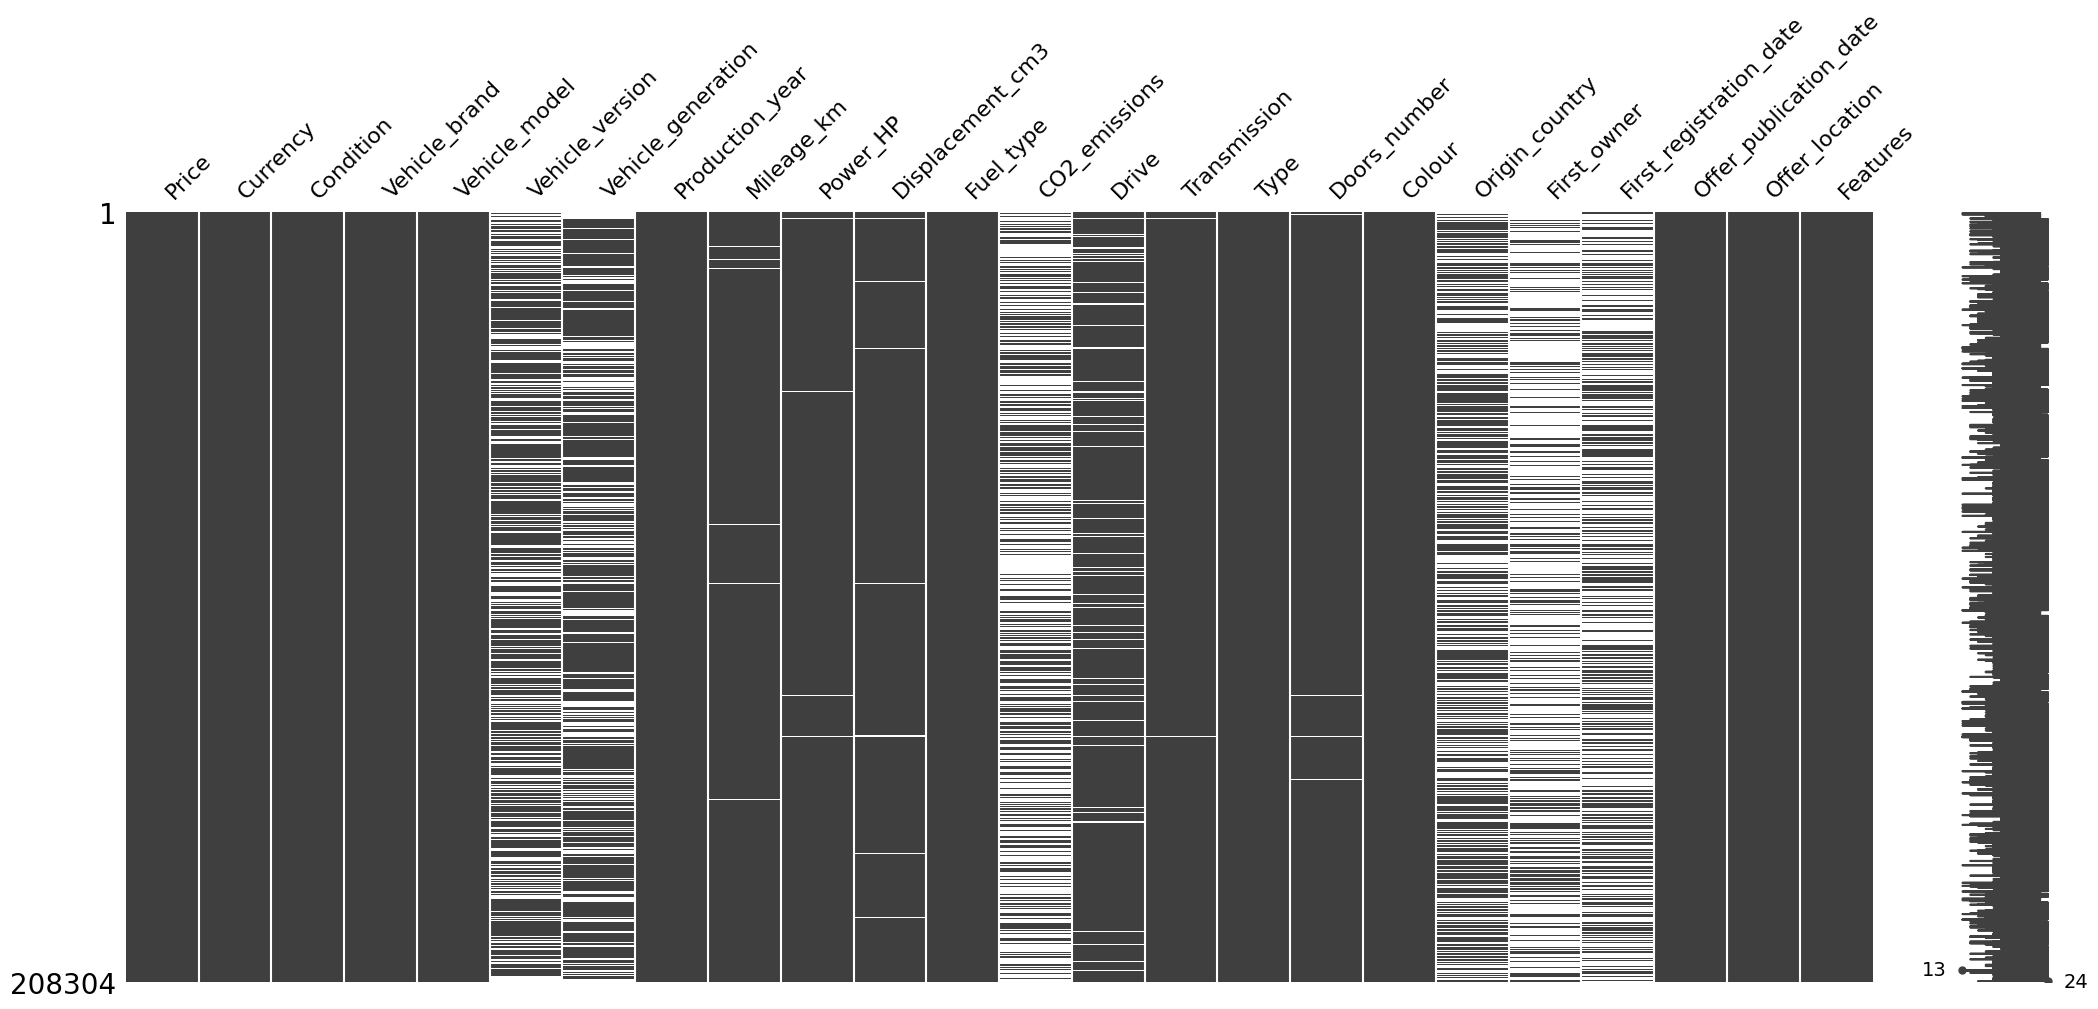

In [12]:
# Visualizing null values
msno.matrix(df);

In [13]:
# Checking the percentage of null values in each column
round(df.isna().mean()*100,2)


,0
Price,0.00
Currency,0.00
Condition,0.00
Vehicle_brand,0.00
Vehicle_model,0.00
Vehicle_version,33.71
Vehicle_generation,29.02
Production_year,0.00
Mileage_km,0.47
Power_HP,0.31


### 1.5.1. Dropping Columns with Significant Missing Values  

**Columns to be Dropped**:  
- `First_registration_date`, `Vehicle_version`, `Vehicle_generation`, and `Origin_country`.

**Reason**:  
- These columns contain a significant percentage of null values.  
- Attempting to retrieve or impute the missing data may introduce bias into the dataset.


In [14]:
# Dropping First_registration_date
df.drop(['First_registration_date','Vehicle_version','Vehicle_generation','Origin_country'], axis=1, inplace=True)

### 1.5.2 Handling Missing Values in the CO2 Emissions Column

Initially, I considered retaining the `CO2_emissions` column due to the valuable insights it could potentially provide. My initial thought was to check whether these were EVs, but that appears not to be the case. Then I considered applying grouped imputation based on related features to estimate the missing values. However, upon further evaluation, I realized that this approach could introduce significant bias, especially given that the column was missing 55% of its observations and the fact that it is not correleted with any other feature as shown in the [correlation matrix below](#####co2-emissions-correlation-table)

After weighing the trade-offs, I decided to drop the `CO2_emissions` column from the dataset. While it had the potential to offer useful insights, the high proportion of missing values presented a substantial risk of bias, which could negatively affect the analysis. Therefore, removing the column was the more prudent decision to ensure data integrity and the reliability of the results.

In [15]:
df[df['CO2_emissions'].isna()].sample(5)

,Price,Currency,Condition,Vehicle_brand,Vehicle_model,Production_year,Mileage_km,Power_HP,Displacement_cm3,Fuel_type,CO2_emissions,Drive,Transmission,Type,Doors_number,Colour,First_owner,Offer_publication_date,Offer_location,Features
3999,10900,PLN,Used,Audi,A3,1996,120000.0,290.0,1781.0,Gasoline + LPG,NaN,Front wheels,Manual,compact,3.0,white,NaN,2021-04-30,"Pszczółki, gdański, Pomorskie","['ABS', 'Electric front windows', 'Drivers air..."
149417,60000,PLN,Used,Renault,Master,2006,219452.0,101.0,2464.0,Diesel,NaN,Front wheels,Manual,minivan,2.0,other,NaN,2021-04-25,"Powidz, słupecki, Wielkopolskie","['ABS', 'Electric front windows', 'Drivers air..."
20140,29000,PLN,Used,BMW,Seria 1,2011,290000.0,184.0,1995.0,Diesel,NaN,Rear wheels,Manual,compact,5.0,white,NaN,2021-05-01,"Olkusz, olkuski, Małopolskie","['ABS', 'CD', 'Blind spot sensor', 'Rear parki..."
197165,6999,PLN,Used,Volkswagen,Polo,2003,155854.0,64.0,1198.0,Gasoline,NaN,Front wheels,Manual,city_cars,5.0,silver,NaN,2021-04-30,"Zakrzewo 14 - 87-220 Radzyń Chełmiński, grudzi...","['ABS', 'Electric front windows', 'Drivers air..."
33249,289900,PLN,New,BMW,X3,2021,NaN,292.0,1998.0,Hybrid,NaN,4x4 (attached automatically),Automatic,SUV,5.0,blue,NaN,2021-05-04,"Wschodnia 9 - 62-080 Swadzim, poznański, Wielk...",[]


##### CO2 Emissions Correlation Table 

In [16]:
# Checking numerical features that are correleted to CO2 emissions
df_num = df.select_dtypes(include=['int64','float64','datetime64[ns]'])
df_num.corr()['CO2_emissions'].sort_values(ascending=False)


,CO2_emissions
CO2_emissions,1.000000
Displacement_cm3,0.020508
Power_HP,0.012352
Mileage_km,0.004679
Price,-0.001300
Doors_number,-0.004102
Offer_publication_date,-0.006416


In [17]:
# Dropping the CO2_emissions column
df.drop('CO2_emissions', axis=1, inplace=True)

### 1.5.3 Handling Missing Values in the Drive Train Column

Although the `Drive Train` column appeared to be missing over 15,000 observations, it was determined that many of these values could be retrieved. This was possible because the same car brand/model appeared multiple times in the dataset, allowing for imputation based on existing records.

A function was created to loop through the dataset and attempt to fill in the missing values by referencing the car brand/model. As a result, 14,941 missing values were successfully retrieved. The remaining approximately 150 observations, for which no data could be retrieved, were dropped from the dataset.

With this approach, I recovered a significant portion of the missing data while maintaining the integrity of the dataset by removing only the rows that could not be accurately filled.


In [18]:
# Filtering rows with non-null 'Drive' to build the mapping
non_null_drive_df = df.dropna(subset=['Drive'])

In [19]:
# Creating the mapping of (brand, model) to 'Drive' using a dictionary comprehension
brand_model_to_drive_mapping = {
    (row['Vehicle_brand'], row['Vehicle_model']): row['Drive']
    for _, row in non_null_drive_df.iterrows()
}

In [ ]:
retrieved_drive_count = 0 # Counter to count the retrieved Drive values

# Defining a function to fill missing values in the Drive column
def impute_drive(row):
    global retrieved_drive_count
    brand_model_key = (row['Vehicle_brand'], row['Vehicle_model'])
    if pd.isnull(row['Drive']) and brand_model_key in brand_model_to_drive_mapping:
        retrieved_drive_count += 1
        return brand_model_to_drive_mapping[brand_model_key]
    return row['Drive']

In [21]:
# Applying the function across the DataFrame
df['Drive'] = df.apply(impute_drive, axis=1)

# Printing the count of retreived drive types
print(f"Number of drives retrieved from mapping: {retrieved_drive_count}")

Number of drives retrieved from mapping: 14941


### 1.5.4 Handling Missing Values in the First Owner Column

The `First Owner` column is a binary field that indicates whether an individual is the first owner of the vehicle, with a value of "Yes" for first owners. The value counts below show that null values in this column likely represent vehicles that are not first owned.

Given this context, it was decided that the null values in the `First Owner` column should be replaced with "No," as they most likely correspond to non-first owners. This approach allows us to retain the column's structure while ensuring that the dataset remains complete and consistent.


In [22]:
df.First_owner.value_counts()

,count
First_owner,
Yes,65094


In [23]:
# Replacing nulls in first_owner column with 'No
df.First_owner.fillna('No', inplace=True)

In [24]:
df.First_owner.value_counts()

,count
First_owner,
No,143210
Yes,65094


### 1.5.5. Handling Remaining Null Values

After addressing the major sources of missing data, the remaining columns were found to contain only a small proportion of null values. Given the negligible impact of these missing observations on the overall dataset, they were removed to maintain data integrity.

In [25]:
# Dropping the remaining null values
df.dropna(inplace=True)

In [26]:
# Ensuring there are no more null values
df.isna().sum()

,0
Price,0
Currency,0
Condition,0
Vehicle_brand,0
Vehicle_model,0
Production_year,0
Mileage_km,0
Power_HP,0
Displacement_cm3,0
Fuel_type,0


In [27]:
# New shape of data after dropping some observations and some columns
df.shape

(203936, 19)

## 1.6. Currency Standardization

To ensure consistency and comparability across the dataset, prices were standardized to a single currency (CAD). A total of 242 observations were recorded in EUR, while the rest were in PLN. All prices were converted to CAD using the average exchange rates from 2021.


In [28]:
df.Currency.value_counts()

,count
Currency,
PLN,203694
EUR,242


In [29]:
# Getting the minimum and maximum dates
min_date = df['Offer_publication_date'].min()
max_date = df['Offer_publication_date'].max()

# Printing the date range in the data
print(f"Date range for Offer_publication_date: {min_date} to {max_date}")


Date range for Offer_publication_date: 2021-03-26 00:00:00 to 2021-05-05 00:00:00


In [30]:
# Defining the conversion rates in 2021
EUR_to_CAD = 1.4829 # Average in 2021
PLN_to_CAD = 0.3249 # Averga in 2021 for simplicity

In [31]:
# Function to convert price to CAD based on currency
def convert_to_cad(row):
    if row['Currency'] == 'EUR':
        return round(row['Price'] * EUR_to_CAD)
    else:
        return round(row['Price'] * PLN_to_CAD)

In [32]:
# Apply the conversion to create a new 'Price_CAD' column
df['Price_CAD'] = df.apply(convert_to_cad, axis=1)

In [33]:
# Dropping the original price and currency columns
df.drop(['Currency','Price'], axis=1, inplace=True)

## 1.7. Adding an Age Column

Although the production year is available in the dataset, I calculated the age of each vehicle by subtracting the production year from the year of offer. This provides the vehicle age in years.

This approach was chosen because age is more intuitive and straightforward to interpret, particularly for clustering purposes.


In [34]:
# Adding a new column to capture number of years from production to offer
df['Years_From_Production_To_Offer'] = df['Offer_publication_date'].dt.year - df['Production_year']

# 2. Exploratory Data Analysis (EDA)

## 2.1. Descriptive Statistics of Numeric Variables

The descriptive statistics reveal several key points about the dataset:

- There are significant outliers, particularly in the **Mileage_km** and **Price_CAD** columns. For instance, the **maximum mileage** is extremely high at **1,111,111,111 km**, which is unrealistic and suggests a data entry error or extreme outlier. Similarly, the **maximum price** of **2,273,975 CAD** is much higher than the 75th percentile value of **24,335 CAD**, possibly indicating the presence of rare or luxury vehicles.

- The **mean price** (**20,045.96 CAD**) is significantly higher than its **median** (**11,371.00 CAD**), which is a direct result of the extreme outliers in the price data. This shows that the data distribution is skewed to the right, with a few high-priced vehicles pushing the mean upward.

The above insights highlight the presence of outliers that may need to be addressed for more accurate clustering.

In [35]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Production_year,203936.0,2012.031206,1915.0,2008.0,2012.0,2017.0,2021.0,6.915756
Mileage_km,203936.0,146534.143413,1.0,55437.0,145421.0,207000.0,1111111111.0,2514211.999946
Power_HP,203936.0,151.18395,1.0,105.0,136.0,170.0,1300.0,76.468747
Displacement_cm3,203936.0,1882.53355,400.0,1461.0,1798.0,1997.0,8400.0,728.479601
Doors_number,203936.0,4.63722,1.0,5.0,5.0,5.0,55.0,0.768256
Offer_publication_date,203936,2021-04-30 03:23:51.131334912,2021-03-26 00:00:00,2021-04-28 00:00:00,2021-04-30 00:00:00,2021-05-03 00:00:00,2021-05-05 00:00:00,NaN
Price_CAD,203936.0,20045.962439,190.0,5686.0,11371.0,24335.0,2273975.0,27938.146302
Years_From_Production_To_Offer,203936.0,8.968794,0.0,4.0,9.0,13.0,106.0,6.915756


In [ ]:
# Download Preprocessed Data
df.to_csv('preprocessed_data.csv', index=False)

## 2.2. Univariate Analysis

### 2.2.1. Numeric Variables
#### Insights from Histograms and Box Plots

1. **Price_CAD**:
   - Most prices are clustered at the lower end, with very few high-priced vehicles causing significant outliers.
   - These outliers skew the data and inflate the price distribution.

2. **Mileage_km**:
   - Majority of vehicles have reasonable mileage, but there’s a massive unrealistic outlier at over 1 billion km.
   - This clearly indicates data entry errors or extreme anomalies.

3. **Power_HP**:
   - Most cars fall within a realistic horsepower range (around 100–200 HP), but there are a few extreme outliers above 600 HP.
   - These may represent luxury or sports vehicles.

4. **Displacement_cm3**:
   - Engine sizes are mostly concentrated between 1000–2000 cm³, which is typical for most vehicles.
   - Outliers above 6000 cm³ suggest the presence of specialized vehicles (e.g., trucks or high-performance cars).
5. **Years_From_Production_To_Offer**:
   - Most vehicles are relatively new (0–20 years old), with the majority around 10 years.
   - A few extreme values, such as 100 years, likely indicate data errors or rare vintage vehicles.

### Takeaways:
- The data contains significant outliers that need cleaning or handling before further analysis.
- Skewed distributions like price and mileage could distort clustering results without normalization or outlier removal.


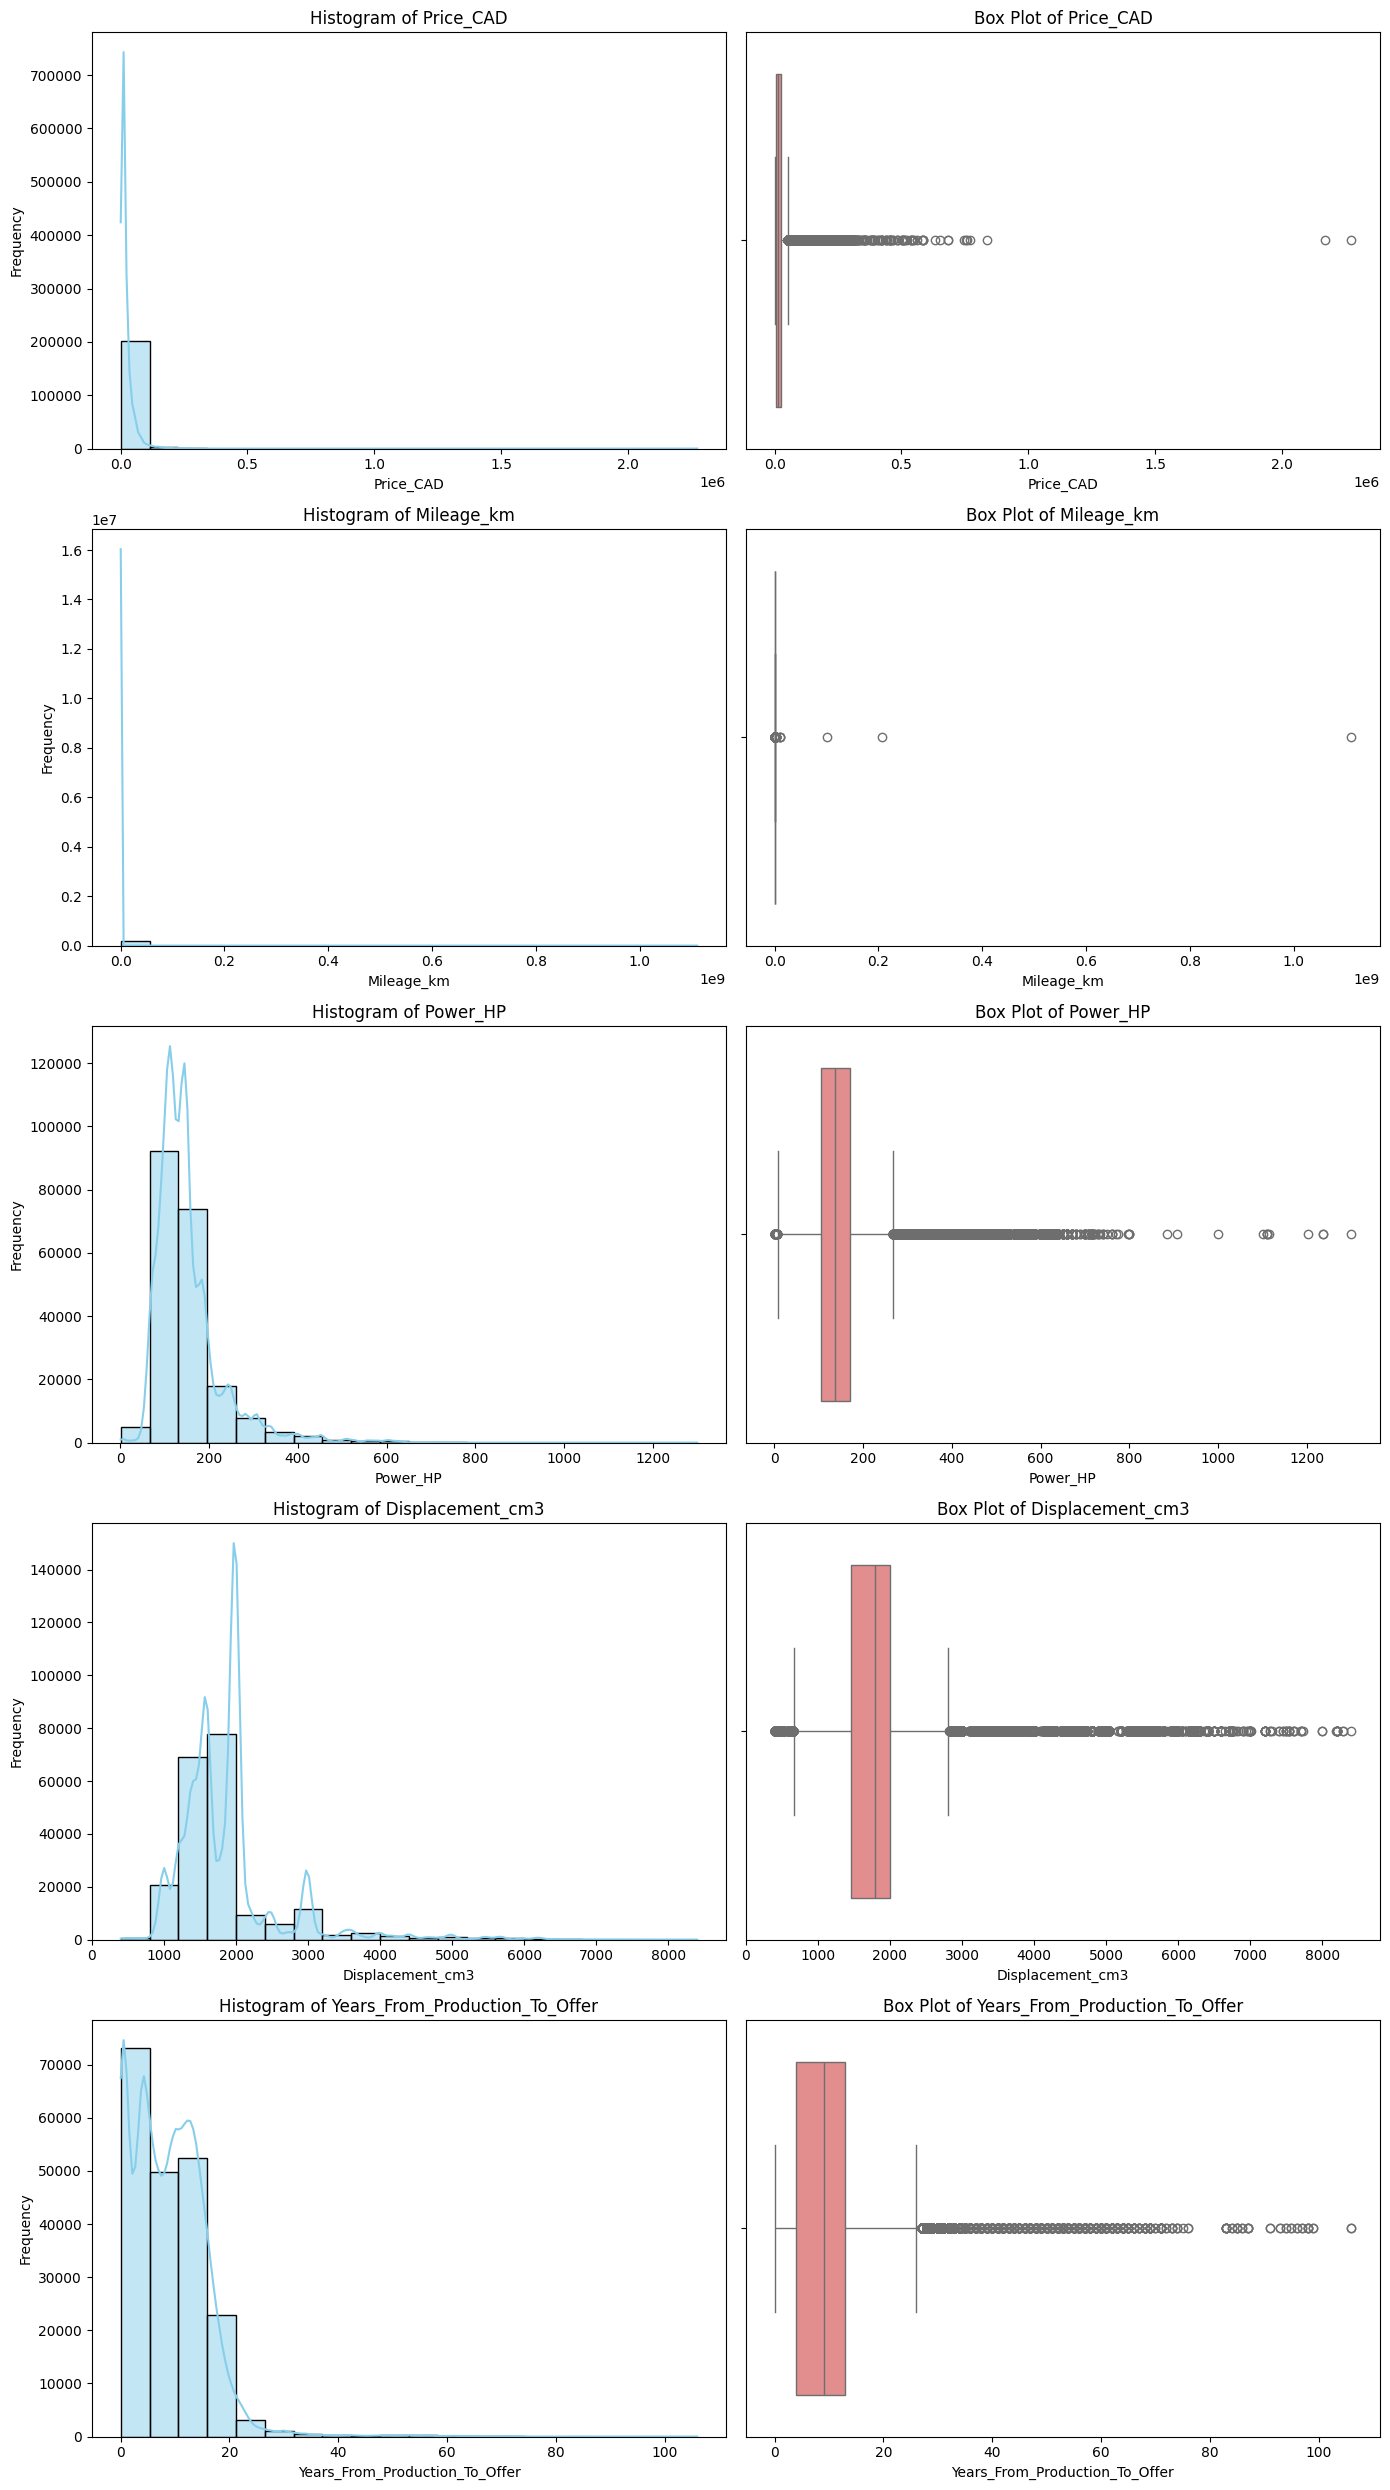

In [37]:
# Identify numeric columns of interest
numeric_cols = ['Price_CAD', 'Mileage_km', 'Power_HP', 'Displacement_cm3', 'Years_From_Production_To_Offer']

# Create a grid of histograms and box plots
fig, axes = plt.subplots(len(numeric_cols), 2, figsize=(14, 5 * len(numeric_cols)))

for i, col in enumerate(numeric_cols):
    # Histogram (left)
    sns.histplot(df[col], kde=True, ax=axes[i, 0], color="skyblue", bins=20)
    axes[i, 0].set_title(f'Histogram of {col}')
    axes[i, 0].set_xlabel(col)
    axes[i, 0].set_ylabel('Frequency')

    # Boxplot (right)
    sns.boxplot(x=df[col], ax=axes[i, 1], color="lightcoral")
    axes[i, 1].set_title(f'Box Plot of {col}')
    axes[i, 1].set_xlabel(col)

plt.tight_layout()
plt.show()


### 2.2.2. Categorical Variables

- **Most Advertised Brands:**  
  Volkswagen is the most advertised car brand, followed closely by BMW. Audi, Opel, and Ford complete the top five most advertised brands.

- **Drivetrain:**  
  The majority of vehicles are front-wheel drive, with approximately 149,000 out of over 200,000+ total vehicles.

- **Vehicle Types:**  
  SUVs are the most advertised category, followed by station wagons and sedans.

- **Condition:**  
  Most of the vehicles are used, with over 180,000 out of the 200,000+ being second-hand.

- **Transmission Type:**  
  Surprisingly, manual transmission is more common, with approximately 132,000 vehicles out of over 200,000

In [38]:
df.Vehicle_brand.value_counts().head(10)

,count
Vehicle_brand,
Volkswagen,18018
BMW,16491
Audi,16303
Opel,16121
Ford,15864
Mercedes-Benz,11827
Renault,10504
Toyota,10149
Škoda,10033


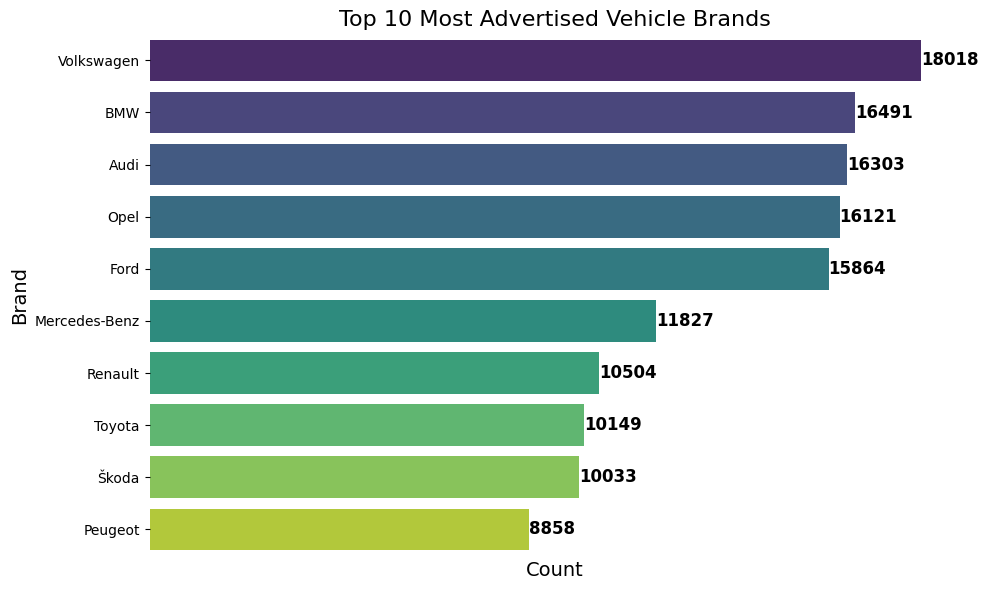

In [39]:
# Get the top 10 most advertised brands
top_brands = df['Vehicle_brand'].value_counts().head(10)

# Set up the plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_brands.values, y=top_brands.index, palette='viridis')

# Add data labels
for i, value in enumerate(top_brands.values):
    plt.text(value + 0.5, i, str(value), va='center', fontsize=12, fontweight='bold')

# Add titles and labels
plt.title('Top 10 Most Advertised Vehicle Brands', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Brand', fontsize=14)

# Remove xticks
plt.xticks([])
# Remove the border (spines) around the chart
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)


# Display the plot
plt.tight_layout()
plt.show()


In [40]:
def plot_category_distribution(df, column):
    """
    This function plots the distribution of categories in a specified categorical column.

    Arguments:
    df : pandas DataFrame
        The dataset containing the categorical column of interest.
    column : str
        The name of the categorical column to analyze.

    Returns:
    None
    """
    # Get the distribution of all categories
    category_counts = df[column].value_counts()

    # Set up the plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x=category_counts.values, y=category_counts.index, palette='viridis')

    # Add data labels
    for i, value in enumerate(category_counts.values):
        plt.text(value + 0.5, i, str(value), va='center', fontsize=12, fontweight='bold')

    # Generate dynamic title reflecting the distribution
    title = f"Distribution of Car {column.replace('_', ' ').title()}"

    # Add titles and labels
    plt.title(title, fontsize=16)
    plt.xlabel('Count', fontsize=14)
    plt.ylabel(column.replace('_', ' ').title(), fontsize=14)

    # Remove xticks
    plt.xticks([])

    # Remove the border (spines) around the chart
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)

    # Display the plot
    plt.tight_layout()
    plt.show()


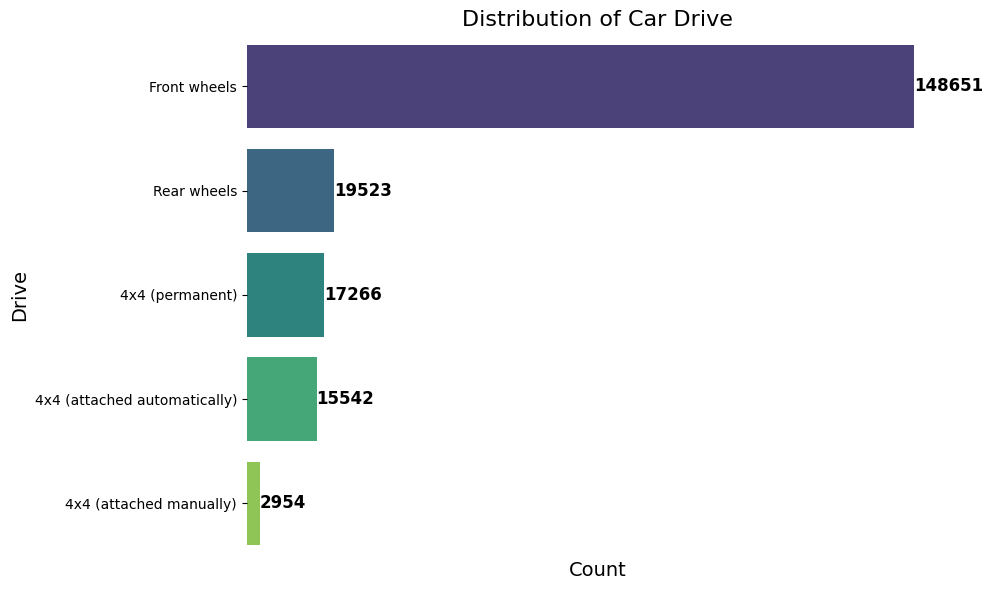

In [41]:
# Plotting distribution of drive train across ads
plot_category_distribution(df, 'Drive')

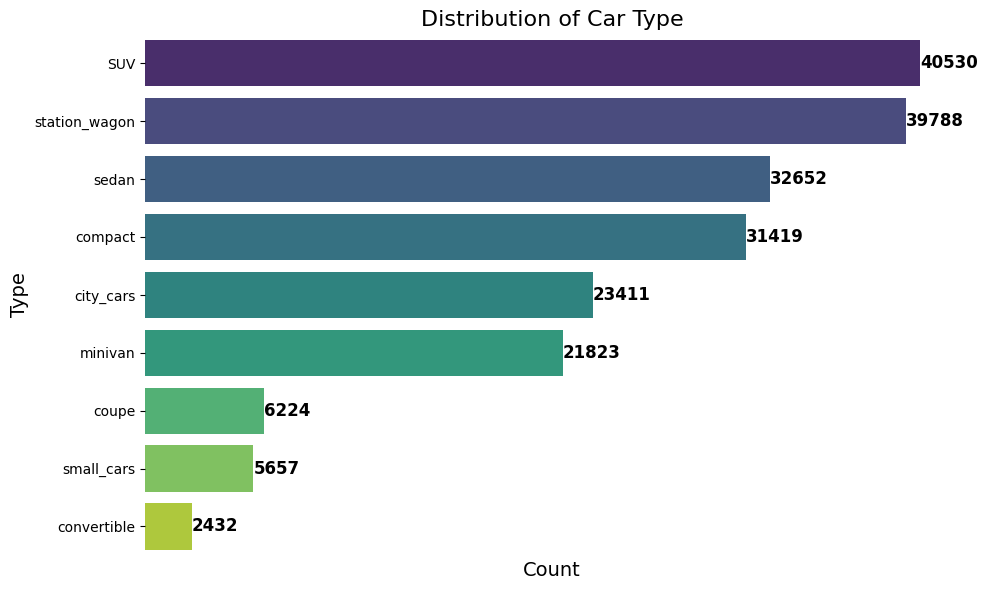

In [42]:
# Plotting distribution of car type across ads
plot_category_distribution(df, 'Type')

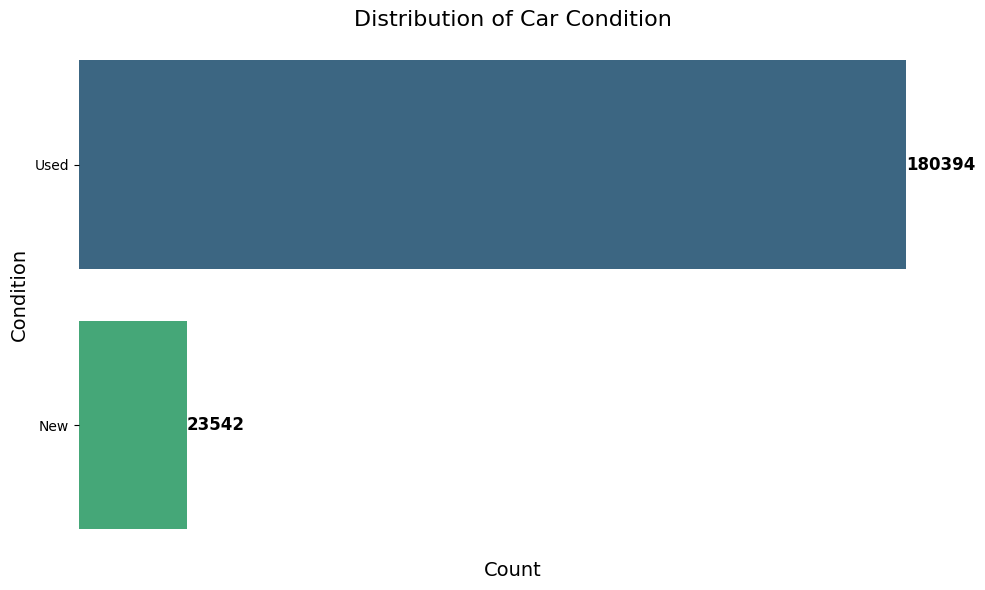

In [43]:
# Plotting distribution of car condition across ads
plot_category_distribution(df, 'Condition')

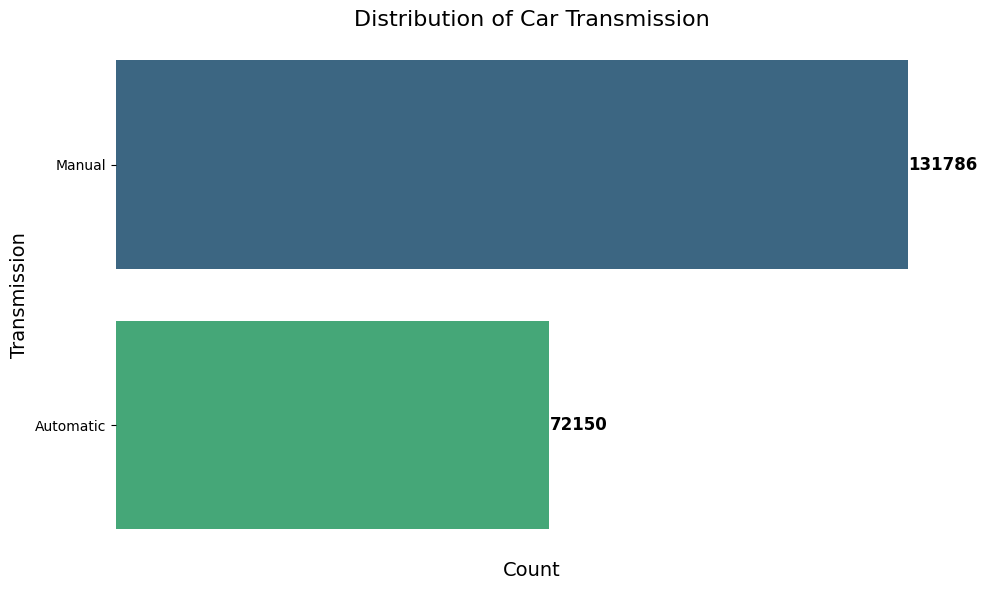

In [44]:
# Plotting distribution of car transmission across ads
plot_category_distribution(df, 'Transmission')

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 203936 entries, 0 to 208303
Data columns (total 19 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   Condition                       203936 non-null  object        
 1   Vehicle_brand                   203936 non-null  object        
 2   Vehicle_model                   203936 non-null  object        
 3   Production_year                 203936 non-null  int32         
 4   Mileage_km                      203936 non-null  float64       
 5   Power_HP                        203936 non-null  float64       
 6   Displacement_cm3                203936 non-null  float64       
 7   Fuel_type                       203936 non-null  object        
 8   Drive                           203936 non-null  object        
 9   Transmission                    203936 non-null  object        
 10  Type                            203936 non-null  object      

## 2.3. Multivariate and Bivariate Analyses

### Insights from Correlation Matrix

- **Price_CAD** has a strong positive correlation with **Power_HP** (0.63) and **Displacement_cm3** (0.36), suggesting higher-priced vehicles often have more horsepower and larger engines.  
- **Price_CAD** also has a moderate positive correlation with **Production_year** (0.43), confirming that newer cars tend to be more expensive.  
- **Displacement_cm3** is highly correlated with **Power_HP** (0.81), which is expected as vehicles with larger engine displacements generally deliver higher horsepower.  
- **Mileage_km** shows weak or negligible correlation with most variables, suggesting mileage has limited direct impact on features like price, power, or production year.  
- **Doors_number** has a slight positive correlation with **Price_CAD** (0.25), indicating vehicles with more doors might be slightly more expensive, which i think is interesting

### Insights from Scatterplots

Based on the relationships identified in the correlation matrix, **Power**, **Displacement**, and **Age** were plotted against **Price** to visualize their relationships:

- **Power** and **Displacement** both show a positive correlation with **Price**, indicating that higher power and engine displacement generally correspond to higher prices.
- **Age** shows a weak negative correlation with **Price**, suggesting that older vehicles tend to have lower prices. This could be attributed to the depreciation of vehicles over time, although certain vintage or classic cars may deviate from this trend, presenting exceptions or anomalies.

These scatterplots visually confirm the relationships between these variables and price, highlighting expected trends as well as potential outliers.



Key Takeaways
- Engine-related features (**Power_HP** and **Displacement_cm3**) are stronger indicators of price.  
- The age of the vehicle inversely affects price, as newer cars tend to cost more.  
- Mileage has minimal influence on other variables, possibly indicating additional context is needed for its impact.  


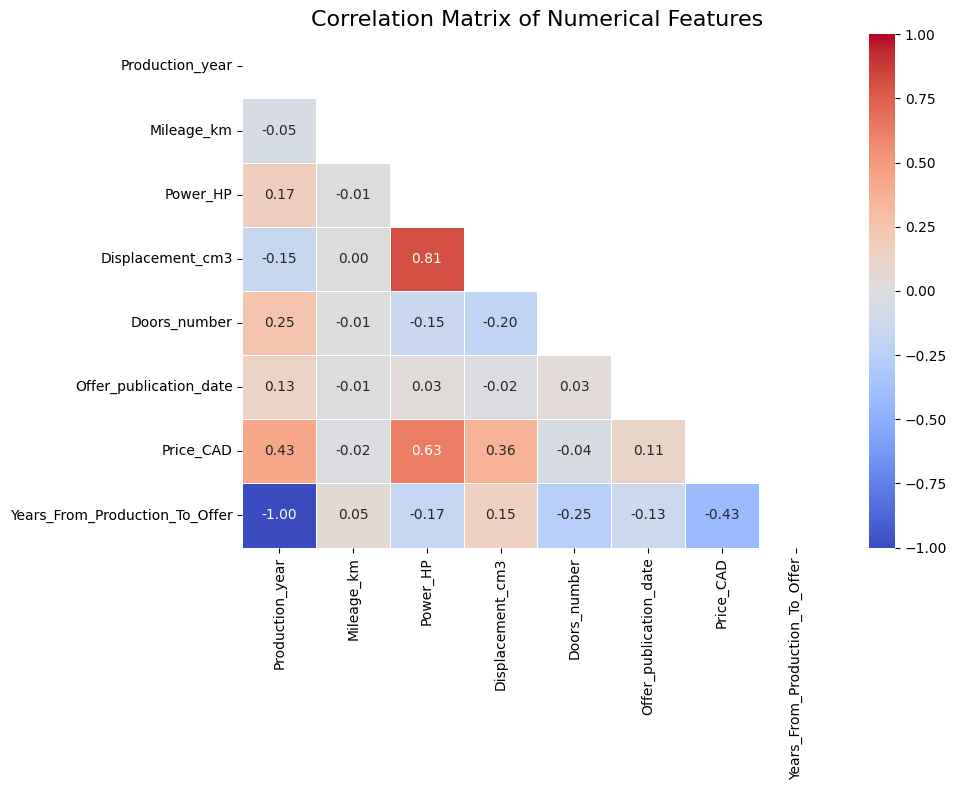

In [46]:
# Calculate the correlation matrix
df_num = df.select_dtypes(include=['number', 'datetime64[ns]'])
corr_matrix = df_num.corr()

# Set up the plot
plt.figure(figsize=(10, 8))

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Create the heatmap with the mask
sns.heatmap(corr_matrix, annot=True, fmt='.2f', mask=mask, cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1)

# Add title
plt.title('Correlation Matrix of Numerical Features', fontsize=16)

# Display the plot
plt.tight_layout()
plt.show()


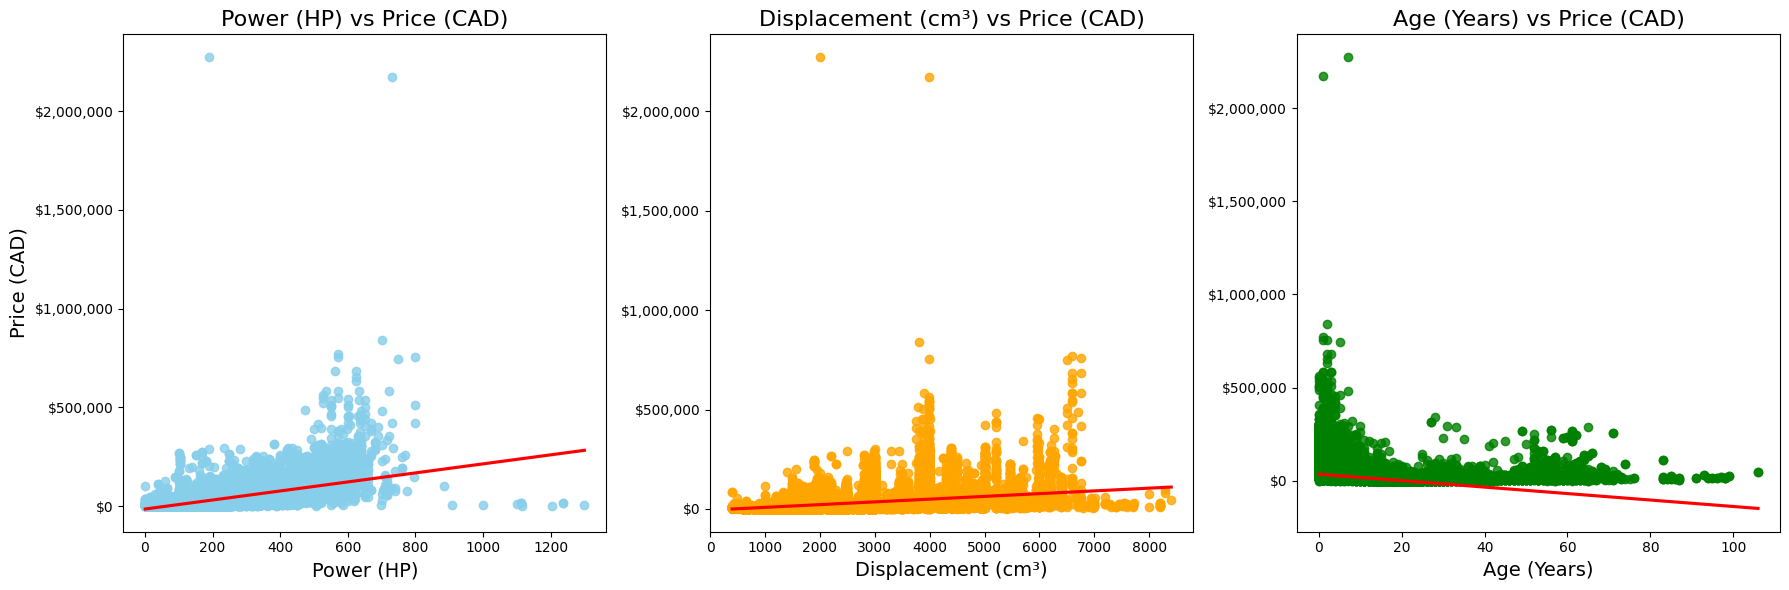

In [47]:
# Formatter function to format y-axis as currency
def currency_format(x, pos):
    return f'${x:,.0f}'  # Format as currency with commas and no decimal points

# Set up the plot
plt.figure(figsize=(18, 6))

# Regression plot for Power_HP vs Price_CAD
plt.subplot(1, 3, 1)  # 1 row, 3 columns, first subplot
sns.regplot(x=df['Power_HP'], y=df['Price_CAD'], scatter_kws={'color': 'skyblue'}, line_kws={'color': 'red'})
plt.title('Power (HP) vs Price (CAD)', fontsize=16)
plt.xlabel('Power (HP)', fontsize=14)
plt.ylabel('Price (CAD)', fontsize=14)

# Format y-axis to show currency
plt.gca().yaxis.set_major_formatter(FuncFormatter(currency_format))

# Regression plot for Displacement_cm3 vs Price_CAD
plt.subplot(1, 3, 2)  # 1 row, 3 columns, second subplot
sns.regplot(x=df['Displacement_cm3'], y=df['Price_CAD'], scatter_kws={'color': 'orange'}, line_kws={'color': 'red'})
plt.title('Displacement (cm³) vs Price (CAD)', fontsize=16)
plt.xlabel('Displacement (cm³)', fontsize=14)
plt.ylabel('', fontsize=14)

# Format y-axis to show currency
plt.gca().yaxis.set_major_formatter(FuncFormatter(currency_format))

# Regression plot for Years_From_Production_To_Offer vs Price_CAD
plt.subplot(1, 3, 3)  # 1 row, 3 columns, third subplot
sns.regplot(x=df['Years_From_Production_To_Offer'], y=df['Price_CAD'], scatter_kws={'color': 'green'}, line_kws={'color': 'red'})
plt.title('Age (Years) vs Price (CAD)', fontsize=16)
plt.xlabel('Age (Years)', fontsize=14)
plt.ylabel('', fontsize=14)

# Format y-axis to show currency
plt.gca().yaxis.set_major_formatter(FuncFormatter(currency_format))

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()


# 3. Clustering with K Prototypes

## 3.1. Overview

- **Why K Prototypes**:  
   K Prototypes was chosen due to its ability to handle both categorical and numerical features, making it well-suited for the dataset. A workaround could have been one-hot encoding the categorical variables; however, this would complicate cluster interpretation since Euclidean or Manhattan distance, commonly employed in clustering algorithms, is not ordinarily suited for  binary data created by one-hot encoding. K prototypes employ a dissimilarity metric for categorical features and Euclidean for numeric data and consolidates both.


- **Sampling and Data Preparation**:  
  - A random sample of 5,000 records was selected from the entire dataset to determine the optimal number of clusters (k).  
  - A larger sample of 20,000 records was then used for the actual clustering algorithm to ensure robustness. Clustering the entire dataset would have been computationally intensive.

- **Outlier Removal and Feature Scaling**:  
  - Outliers were removed using the Interquartile Range (IQR) method. As shown in the EDA, the dataset contained many outliers.  
  - Given that K Prototypes is highly sensitive to outliers, they were dropped to improve the model's clustering performance.
- Further, the numeric features were scaled, as K Prototypes is distance-based and sensitive to differences in the magnitude of features.  
  - Scaling ensures that numeric features like price and mileage are treated equally in the clustering process.

- **Selection of Optimal k**:  
  - The optimal value for k was determined using both the Elbow Method and Silhouette Scores, which helped assess the number of clusters that best balanced within-cluster variance and inter-cluster distance.

- **Feature Selection for Clustering**:  
  - Certain features were selected based on their business relevance and insights from the exploratory data analysis (EDA), ensuring that the most impactful variables were used in the clustering process.

- **Dimensionality Reduction**:  
  - Given the high dimensionality of the data, Principal Component Analysis (PCA) was applied to reduce the dataset to 2 principal components (PCs).  
  - Categorical columns were one-hot encoded so PCA could be applied.  

  - These 2 PCs were then plotted in a 2D space to visualize the resulting clusters.

- **Visualization**:  
  - Cluster labels, generated by the trained K Prototypes model, were assigned to all observations in the dataset, including those that were not used to train the model.  
  - The resulting clusters were visualized in the 2D PCA space, providing an intuitive representation of the data's grouping.



In [48]:
# freeing up memory
import gc
gc.collect()

30197

## 3.2. Data Preparation

This step involves feature selection, scaling of the numeric features, and outlier removal, all consolidated into a reusable function.

#### Features Selected

A total of 5 features were selected for clustering: 5 numeric and 1 categorical. The selected features include:

- **Mileage_km**
- **Power_HP**
- **Displacement_cm3**
- **Price_CAD**
- **Years_From_Production_To_Offer**
- **Type**

These features were chosen because they provide insights into car performance, body type, price, and age—key defining characteristics of a car. These features were prioritized for their maximum business impact, as they offer a comprehensive view of the car's market and technical attributes.

Other categorical features, such as car condition, transmission, and drivetrain, were initially considered but later excluded. These features exhibited low variance, resulting in clusters dominated by a single category. To adhere to *Occam's Razor* (favoring simplicity when added complexity provides no benefit), these features were dropped.

While **Displacement_cm3** and **Power_HP** are highly correlated, both were retained. This decision acknowledges that modern vehicles can have smaller engines that still deliver high horsepower. Keeping both features allows for a nuanced representation of vehicle specifications.

#### Scaling

**Standard Scaler** was used to scale the numeric features. This step is crucial to ensure that features with larger magnitudes do not disproportionately influence the clustering results.

#### Outliers

The numeric features contained significant outliers or anomalies. While robust clustering algorithms like DBSCAN or K-Medoids can handle outliers effectively, **K-Prototypes** is sensitive to outliers but was chosen for reasons discussed previously. This necessitated the removal of outliers.

The **Interquartile Range (IQR)** method was employed to identify and remove outliers.


In [62]:
cluster_df = df.sample(n=5000, random_state=42) # Sampling a few observations for selecting optimal K
cluster_df.shape

(5000, 19)

In [50]:
# Function to select features to be used for clustering
def select_and_prepare_features(df, features, categorical_columns):
    """
    Selects specific features and ensures categorical columns are strings.

    Parameters:
    df (DataFrame): The input DataFrame.
    features (list): List of column names to keep.
    categorical_columns (list): List of categorical column names to convert to string.

    Returns:
    DataFrame: Prepared DataFrame with selected features and categorical columns as strings.
    """
    df = df[features].copy()
    for col in categorical_columns:
        df[col] = df[col].astype(str)
    return df


In [51]:
# Function to standardize num features
def standardize_numerical_columns(df, numerical_columns):
    """
    Standardizes numerical columns using StandardScaler and returns both the scaled DataFrame and the scaler.

    Parameters:
    df (DataFrame): The input DataFrame.
    numerical_columns (list): List of numerical column names to standardize.

    Returns:
    DataFrame, StandardScaler: DataFrame with standardized numerical columns and the fitted scaler.
    """
    scaler = StandardScaler()
    df[numerical_columns] = scaler.fit_transform(df[numerical_columns])
    return df, scaler


In [52]:
# function to remove outliers
def remove_outliers(df, numerical_columns):
    """
    Remove outliers from the specified numerical columns using IQR (Interquartile Range).

    Parameters:
    df (DataFrame): The input DataFrame.
    numerical_columns (list): List of numerical column names to remove outliers from.

    Returns:
    DataFrame: The DataFrame with outliers removed.
    """
    # Create a copy of the original DataFrame to avoid modifying the original
    df_cleaned = df.copy()

    for col in numerical_columns:
        # Calculate Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = df_cleaned[col].quantile(0.25)
        Q3 = df_cleaned[col].quantile(0.75)

        # Calculate IQR (Interquartile Range)
        IQR = Q3 - Q1

        # Define the lower and upper bounds for the outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Filter out rows where the value is outside the bounds
        df_cleaned = df_cleaned[(df_cleaned[col] >= lower_bound) & (df_cleaned[col] <= upper_bound)]

    return df_cleaned


In [53]:
# function to obtain the indices of categorical features; this is needed for k prototypes algo
def get_categorical_indices(df, categorical_columns):
    """
    Retrieves the indices of categorical columns for K-Prototypes.

    Parameters:
    df (DataFrame): The input DataFrame.
    categorical_columns (list): List of categorical column names.

    Returns:
    list: List of indices for the categorical columns.
    """
    return [df.columns.get_loc(col) for col in categorical_columns]


In [54]:
# full data prep pipeline
def preprocess_and_cluster(df, features, categorical_columns, numerical_columns):
    """
    Consolidated pipeline to preprocess data for K-Prototypes clustering.

    Steps:
    1. Select features and prepare data types.
    2. Remove outliers.
    3. Standardize numerical columns and return the scaler.
    4. Get indices of categorical columns.

    Parameters:
    df (DataFrame): The input DataFrame.
    features (list): List of column names to keep.
    categorical_columns (list): List of categorical column names.
    numerical_columns (list): List of numerical column names.

    Returns:
    DataFrame, list, StandardScaler: Preprocessed DataFrame, list of categorical column indices, and the fitted scaler.
    """
    print(f"Initial shape of DataFrame before selecting features: {df.shape}")

    # Step 1: Select features and ensure data types
    df = select_and_prepare_features(df, features, categorical_columns)

    # Step 2: Remove outliers
    print(f"Shape before outlier removal: {df.shape}")
    df = remove_outliers(df, numerical_columns)
    print(f"Shape after outlier removal: {df.shape}")

    # Step 3: Standardize numerical columns and get the scaler
    df, scaler = standardize_numerical_columns(df, numerical_columns)

    # Step 4: Get categorical column indices
    categorical_indices = get_categorical_indices(df, categorical_columns)

    return df, categorical_indices, scaler # scaler to be used to inverse transform the data to enable intuitive result interpretation


In [59]:
# Define feature subsets: these are the selected features as discussed above
features = ['Mileage_km', 'Power_HP','Displacement_cm3', 'Price_CAD', 'Years_From_Production_To_Offer','Type']
categorical_columns = ['Type'] # this is important so the index can be recieved and pass into the k proto algo
numerical_columns = ['Mileage_km', 'Power_HP','Displacement_cm3', 'Price_CAD', 'Years_From_Production_To_Offer']

In [68]:
# Apply the preprocessing pipeline
cluster_df, categorical_column_indices, scaler = preprocess_and_cluster(cluster_df, features, categorical_columns, numerical_columns)

# Display the results
print(f"Processed DataFrame shape: {cluster_df.shape}")
print(f"Categorical column indices for K-Prototypes: {categorical_column_indices}")

Initial shape of DataFrame before selecting features: (5000, 19)
Shape before outlier removal: (5000, 6)
Shape after outlier removal: (4101, 6)
Processed DataFrame shape: (4101, 6)
Categorical column indices for K-Prototypes: [5]


## 3.3. Method for Selecting the Optimal Number of Clusters (K) and Evaluating Clustering Performance

The number of clusters, **K**, is the most critical hyperparameter in the K-Prototypes algorithm. One limitation of K-Prototypes is its reliance on specifying K beforehand, making the selection process crucial.

### Approaches to Selecting K

Selecting the optimal K can be subjective, as there is no universally accepted method. However, a combination of domain knowledge and quantitative techniques is often employed:

1. **Elbow Method**  
   The elbow method aims to find the K where the within-cluster variation (cost or inertia) is minimized, and further increases in K result in minimal reduction of this variation. A drawback with the Elbow method is that cost decreases monotonically as K increases, making it difficult to determine the "elbow." Additionally, this method considers only cluster cohesion and not cluster separation. To address this challenge, Silhouette scores were also used to assess the clusters.

2. **Silhouette Scores**  
   Silhouette scores assess clustering performance by measuring how well each data point fits within its assigned cluster compared to other clusters. The scores account for both cluster cohesion and separation. An average silhouette score provides an overall evaluation of clustering performance.

### Silhouette Score for K-Prototypes

Calculating silhouette scores for K-Prototypes is challenging because the standard method relies on Euclidean distance, which is unsuitable for categorical data. To address this:

- A **custom precomputed distance function** was designed to calculate:
  - **Matching dissimilarity** for categorical features.
  - **Euclidean distance** for numeric features.  

This approach aligns with the method used in the K-Prototypes algo, ensuring consistency. The two distances are then combined using a parameter, **alpha**, which serves as a weight to adjust the influence of numerical distances in the final calculation.  
- A higher alpha value increases the emphasis on numerical distances, allowing for flexibility in evaluating different data characteristics.



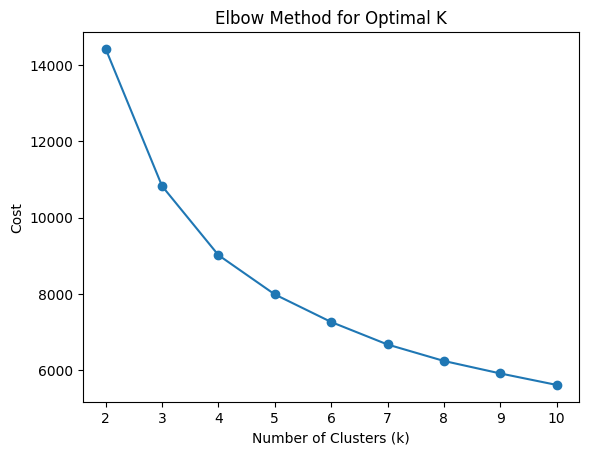

In [ ]:
# This cell may take a long time to run due to the complexity of the operations. 


# Elbow Method: Calculate cost for different values of k
costs = []
k_range = range(2, 11)  # Test for k = 2 to k = 10

for k in k_range:
    kproto = KPrototypes(n_clusters=k, init='Huang', n_init=10, verbose=0, random_state=42)
    kproto.fit(cluster_df, categorical=categorical_column_indices)
    costs.append(kproto.cost_)

# Plot the cost to identify the "elbow"
plt.plot(k_range, costs, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Cost')
plt.xticks(k_range)
plt.show()


In [63]:
# Function to compute a distance matrix for mixed data
def dm_prototypes(dataset, categorical=None, alpha=0.1):
    """
    This function computes a distance matrix for a given dataset using the mixed distance
    function that combines both categorical and numerical features. The distance matrix
    is symmetric and stores the pairwise distances between all data points in the dataset.

    Arguments:
    dataset : pandas DataFrame or numpy array
        The dataset for which the distance matrix is computed. If it's a DataFrame,
        it is converted to a numpy array.
    categorical : list of int, optional
        Indices of categorical features in the dataset. If None, all features are treated as numerical.
    alpha : float, optional (default=0.1)
        A weight parameter to balance the influence of numerical and categorical distances.
        A higher value of alpha gives more weight to the numerical distance.

    Returns:
    numpy array
        A symmetric distance matrix with pairwise distances between data points.
    """

    # Convert the DataFrame to numpy array if dataset is a pandas DataFrame
    if isinstance(dataset, pd.DataFrame):
        dataset = dataset.values  # Convert DataFrame to numpy array

    # Get the number of data points in the dataset
    lenDataset = len(dataset)

    # Initialize an empty distance matrix with zero values
    distance_matrix = np.zeros((lenDataset, lenDataset))

    # Iterate through each pair of data points (i, j) to compute their distance
    for i in range(lenDataset):
        for j in range(i + 1, lenDataset):
            # Compute the distance between data points `i` and `j` using the mixed distance function
            distance = mixed_distance(dataset[i], dataset[j], categorical=categorical, alpha=alpha)

            # Store the computed distance in both [i, j] and [j, i] to ensure symmetry
            distance_matrix[i, j] = distance
            distance_matrix[j, i] = distance  # Ensures symmetry

    # Return the complete distance matrix
    return distance_matrix


In [64]:
# Mixed distance function for K-Prototypes
def mixed_distance(a, b, categorical=None, alpha=0.01):
    """
    This function computes the mixed distance (both categorical and numerical)
    between two data points `a` and `b` for use with the K-Prototypes algorithm.

    Arguments:
    a : array-like
        A data point represented as an array or list.
    b : array-like
        Another data point represented as an array or list.
    categorical : list of int, optional
        Indices of categorical features in the data. If None, the data is assumed to be entirely numerical.
    alpha : float, optional (default=0.01)
        A weight parameter that adjusts the influence of the numerical distance in the final score.
        A higher value of alpha gives more weight to numerical distances.

    Returns:
    float
        The computed mixed distance between the two data points.
    """

    # If no categorical features are specified, calculates the Euclidean distance between the numerical features
    if categorical is None:
        return kPrototypes.euclidean_dissim(a, b)

    else:
        # Separates the categorical and numerical features for both data points `a` and `b`
        cat_indices = categorical

        # Extracts categorical features for both data points `a` and `b`
        a_cat = np.array([a[index] for index in cat_indices]).reshape(1, -1)
        b_cat = np.array([b[index] for index in cat_indices]).reshape(1, -1)

        # Extracts numerical features for both data points `a` and `b`
        a_num = np.array([a[index] for index in range(len(a)) if index not in cat_indices]).reshape(1, -1)
        b_num = np.array([b[index] for index in range(len(b)) if index not in cat_indices]).reshape(1, -1)

        # Computes the categorical distance using matching dissimilarity
        cat_score = matching_dissim(a_cat, b_cat)

        # Computes the numerical distance using Euclidean dissimilarity
        num_score = euclidean_dissim(a_num, b_num)

        # Returns the combined distance as a weighted sum of categorical and numerical distances
        return cat_score + alpha * num_score


In [70]:
# Converting DataFrame to numpy array
data_array = cluster_df.values

In [66]:
gc.collect()

12823

In [ ]:
# This cell takes a very long time to run due to the complexity of the operations. 


# Generating distance matrix
distance_matrix = dm_prototypes(data_array, categorical=categorical_column_indices, alpha=0.1)

In [63]:
gc.collect()

0

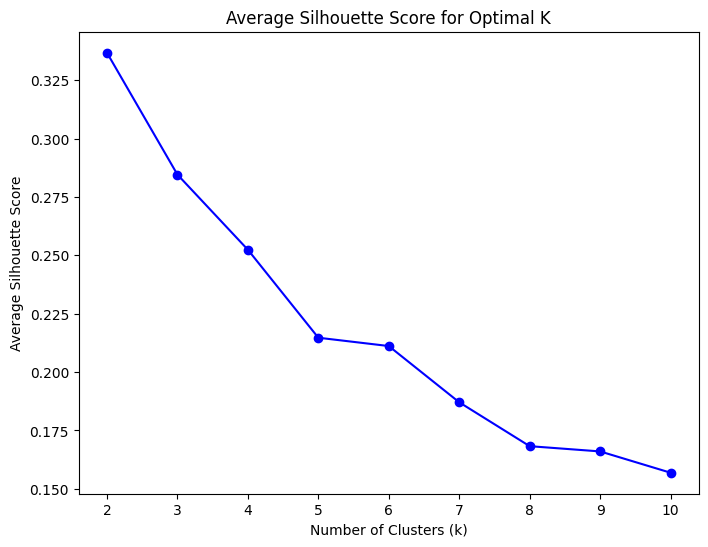

Optimal number of clusters based on Silhouette Score: 2


In [ ]:
# This cell takes a long time to run due to the complexity of the operations. 


# Storing Silhouette scores for different k values
sil_scores = []
k_range = range(2, 11)  # Test for k = 2 to k = 10 (Silhouette score not defined for k=1)

for k in k_range:
    kproto = KPrototypes(n_clusters=k, init='Huang', n_init=10, random_state=42, verbose=0)
    kproto.fit(data_array, categorical=categorical_column_indices)

    # Assign labels to data points
    labels = kproto.labels_

    # Calculate Silhouette Score using the precomputed distance matrix
    sil_score = silhouette_score(distance_matrix, labels, metric="precomputed")
    sil_scores.append(sil_score)

# Plotting the Silhouette scores
plt.figure(figsize=(8, 6))
plt.plot(k_range, sil_scores, marker='o', linestyle='-', color='b')
plt.title('Average Silhouette Score for Optimal K')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Average Silhouette Score')
plt.xticks(k_range)
plt.show()

# Finding and displaying the optimal number of clusters based on the highest Silhouette score
optimal_k = k_range[sil_scores.index(max(sil_scores))]
print(f"Optimal number of clusters based on Silhouette Score: {optimal_k}")

## 3.4. Optimal K Based on Cost and Silhouette Score

As shown in the above plots, **K = 3** was deemed the optimal number of clusters, as it strikes a balance between cost and silhouette score.

- **Silhouette scores** range from -1 to 1, with a score of 1 indicating perfect clustering and -1 indicating poor clustering. Scores between 0.25 and 1 are considered fair.
- Although **K = 2** appears to have a higher silhouette score, I chose **K = 3** because it still yields a fair silhouette score while providing a lower inertia.

Thus, **K = 3** was selected as the optimal choice, balancing both clustering quality and inertia effectively.


## 3.5. Initialization Method: Huang's Initialization



For the initialization of centroids, I selected **Huang's Initialization**. This method was chosen due to its ability to provide a more informed starting point for clustering, improving the chances of achieving better convergence and higher-quality clusters. Huang’s initialization helps mitigate the risk of poor initial placements, which is especially beneficial for high-dimensional and mixed-data-type datasets. This could also lead to faster convergence, reducing computational time and improving overall clustering performance.


In [73]:
gc.collect()

3786

In [74]:
full_cluster_df = df.sample(n=20000, random_state=42) # Sampling approximately 10% of observations for the actual clustering
full_cluster_df.shape

(20000, 19)

In [75]:
# Apply the preprocessing pipeline on the newly sampled data to be used for the actual clustering
full_cluster_df, categorical_column_indices, scaler = preprocess_and_cluster(full_cluster_df, features, categorical_columns, numerical_columns)


# Display the results
print(f"Processed DataFrame shape: {full_cluster_df.shape}")
print(f"Categorical column indices for K-Prototypes: {categorical_column_indices}")

Initial shape of DataFrame before selecting features: (20000, 19)
Shape before outlier removal: (20000, 6)
Shape after outlier removal: (16406, 6)
Processed DataFrame shape: (16406, 6)
Categorical column indices for K-Prototypes: [5]


In [76]:
# Initialize K-Prototypes with k=3
kproto = KPrototypes(n_clusters=3, init='Huang', n_init=10, random_state=42, verbose=0)


In [77]:
full_data_array= full_cluster_df.values

In [78]:
# Fit the model
kproto.fit(full_data_array, categorical=categorical_column_indices)

KPrototypes(gamma=0.5, init='Huang', n_clusters=3, random_state=42)

In [ ]:

# This cell takes a very long time to run due to the complexity of the operations. 

# calculating the distance with the custom function
full_distance_matrix = dm_prototypes(full_data_array, categorical=categorical_column_indices, alpha=0.1)

In [80]:
gc.collect()

0

## 3.6. Cluster Evaluation  


The clustering was evaluated using a combination of intuition, visual inspection, and quantitative metrics. As shown in the plots under the *Cluster Visualization* section, the clusters exhibit good separation with minimal overlap. Further, the distinct centroid values across clusters indicate a meaningful pattern in the grouping. Quantitatively, the silhouette score of **0.28** indicates fair clustering performance. Overall, the K-Prototypes clustering successfully segments the cars into three distinct groups.

In [81]:
# Calculating average silhouette score
avg_sil_score = silhouette_score(full_distance_matrix, kproto.labels_, metric="precomputed")
print(f"Average Silhouette Score: {avg_sil_score}")

Average Silhouette Score: 0.2817853092464942


In [82]:
## Printing cost
print(f"Cost: {kproto.cost_}")

Cost: 43783.4037786304


## 3.7. Cluster Visualization  

Due to the multidimensional nature of the data, visualizing it is not straightforward. To address this, Principal Component Analysis (PCA) was applied to reduce the data to two dimensions for easier visualization. PCA was selected over t-sne because I prioritized reproducibilty and computational efficiency. The categorical feature was one-hot encoded prior to applying PCA. Each observation was then assigned to its respective label. The resulting visualization reveals clear patterns and good cohesion within the clusters; however, the separation between clusters could be further improved.

The PCA visualization in 2D is used primarily to show how cohesive and separated the clusters are. It helps in assessing the overall structure and grouping of the data. However, **insights cannot be directly derived** from the plot itself because the axes represent **principal components (PCs)** that capture the variability in the dataset. These principal components do not have a direct, interpretable meaning related to the original features. For a more meaningful interpretation of the clusters, it's better to focus on the **centroids** of the clusters, which represent the **average values** of the features within each cluster. The centroids provide a clearer understanding of the characteristics that define each cluster.

In [83]:
print(f"Categorical columns: {list(categorical_columns)}")
print(f"Numerical columns: {list(numerical_columns)}")

Categorical columns: ['Type']
Numerical columns: ['Mileage_km', 'Power_HP', 'Displacement_cm3', 'Price_CAD', 'Years_From_Production_To_Offer']


In [84]:
# Convert categorical variables to dummy/indicator variables
cluster_df_dummified = pd.get_dummies(full_cluster_df, columns=categorical_columns, drop_first=True)

# Verify the new dataframe structure
print(f"Shape of dataframe after dummification: {cluster_df_dummified.shape}")


Shape of dataframe after dummification: (16406, 13)


In [ ]:
# Initialize PCA to reduce to 2 components
pca = PCA(n_components=2, random_state=42)

# Fit and transform the data
pca_result = pca.fit_transform(cluster_df_dummified)

# Create a DataFrame with PCA results for visualization
pca_df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = kproto.labels_


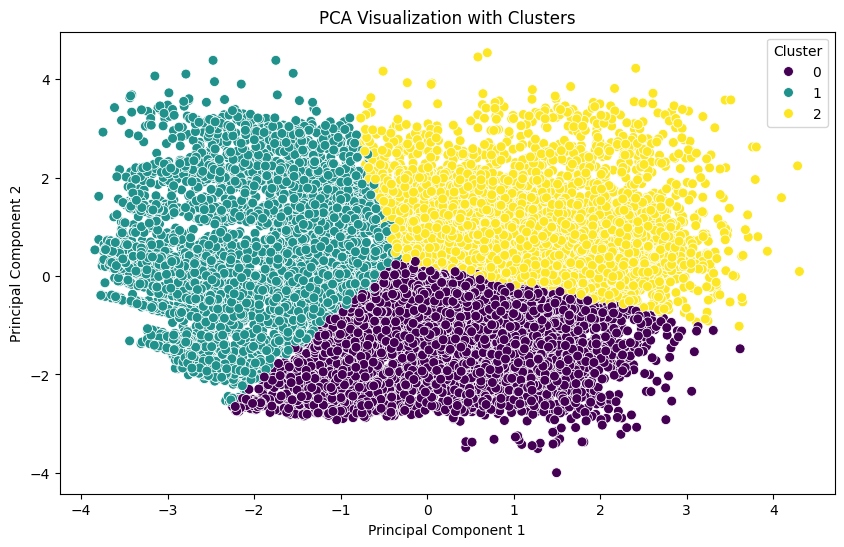

In [86]:
# Plot the PCA results with clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster', palette='viridis', s=50)
plt.title("PCA Visualization with Clusters")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()


## 3.8. Clusters Interpretation  

The clusters were analyzed by assessing their centroids. For K-Prototypes clustering, the centroid of a numeric feature is the average of the observations in the cluster, while for categorical features, it is the mode or most frequent value.

The three identified clusters were:  
- **Older City Commuters (Cluster 0)**  
- **Modern Power Vehicles (Cluster 1)**  
- **Seasoned Family Travelers (Cluster 2)**  

**Older City Commuters**  
This group is dominated by city cars, which are known for their affordability and compactness. These cars have the **smallest engine size**, with an average displacement of **1,402 cm³**, and the **lowest engine power**, averaging **95 HP**. They are mostly **older vehicles**, with an average age of **10 years** and a **high mileage** of about **150,000 km**. As expected for this category, these cars are the **most affordable**, with an average price of **7,173 CAD**. Notably, **37%** of the car ads belong to this segment.

**Modern Power Vehicles**

Vehicles in this cluster are characterized by a good balance of power and efficiency. They have **high engine power**, averaging **145 HP**, despite having a smaller engine size with an average displacement of **1,640 cm³** when compared to vehicles in the seasoned family travelers segment. The group is dominated by **newer SUVs**, with an average age of **3 years** and a relatively **low mileage** of **51,000 km**. These vehicles exemplify efficiency given their engine size-to-power output ratio. However, premium performance comes at a cost, as these cars are the **most expensive**, with an average price of **27,000 CAD**. **34%** of the car ads belong to this group.

**Seasoned Family Travelers**  
This segment consists primarily of station wagons, which are becoming less common but still offer great practicality for families. These are the **oldest vehicles**, with an average age of **12 years**, and have the **highest mileage**, averaging **223,000 km** compared to the other groups. They feature the **largest engine size**, with an average displacement of **1,981 cm³**, and slightly higher engine power than Modern Power Vehicles, averaging **146 HP**. However, these vehicles may not be the most efficient when the engine size-to-power output ratio is considered. They are the **second most affordable**, with an average price of **8,097 CAD**. **29%** of the car ads belong to this cluster.


In [87]:
# Access the cluster centroids from KPrototypes
centroids = kproto.cluster_centroids_

In [88]:
# Prinitng out the array
centroids

array([['0.03492069198145208', '-0.8459897353583886',
        '-0.7468282090958717', '-0.566397916120386', '0.23401668394324',
        'city_cars'],
       ['-1.0488069734382257', '0.4957003491136689',
        '-0.07591833069745715', '1.2965273412737623',
        '-1.0986829300893783', 'SUV'],
       ['0.8531474545687626', '0.5105813242240278', '0.8872873761855687',
        '-0.4782362805169812', '0.6762131502137144', 'station_wagon']],
      dtype='<U32')

In [89]:
# Create df for centroids to allow for easy visualization
centroids_df = pd.DataFrame(centroids, columns=full_cluster_df.columns)


In [90]:
# Inverse transform the numerical columns of centroids_df with the saved scaler to enable intuitive interpretation of the values
centroids_df[numerical_columns] = scaler.inverse_transform(centroids_df[numerical_columns])

# Displaying the centroids with original scale
centroids_df

,Mileage_km,Power_HP,Displacement_cm3,Price_CAD,Years_From_Production_To_Offer,Type
0,149321.241058,95.520660,1402.793892,7173.011432,10.328597,city_cars
1,51063.296296,145.571005,1640.524233,26712.339471,2.831111,SUV
2,223507.111371,146.126125,1981.826736,8097.696474,12.816301,station_wagon


In [111]:
# checking the distributuion of the clusters
pca_df.Cluster.value_counts(normalize=True)

,proportion
Cluster,
0,0.373217
2,0.338778
1,0.288004


## 3.9. Cluster Assignment to the Entire Dataset


### Overview
To validate the clustering model's performance and ensure its insights are representative of the entire dataset, the trained k-prototypes model was applied to all observations. Initially, only 10% of the data was used to build the clustering model. This step assesses how well the model generalizes when applied at scale.

### Key Takeaways
1. **Consistent Cluster Separation:**  
   The 2D plot of the entire dataset shows cluster separation that is visually similar to the plot for the 10% sample used during model training. This indicates that the clusters are stable and well-defined.

2. **Similar Averages and Modes:**  
   The averages and mode of each feature, calculated for the entire dataset grouped by clusters, closely match the centroids identified during the clustering process. This confirms that the clusters retain their original characteristics when applied to the full dataset.

3. **Comparable Cluster Distribution:**  
   The proportion of data points in each cluster across the full dataset is almost identical to the distribution observed in the sample. This consistency reinforces the reliability of the clustering approach.

These insights confirm the **generalizability** of the clustering model to the entire dataset. The insights derived from the 10% sample can be confidently scaled for broader applications.

In [92]:
# apply preprocess_and_cluster funvtion to full df with new var names
full_df, cat_col_ind, Scaler = preprocess_and_cluster(df, features, categorical_columns, numerical_columns)


Initial shape of DataFrame before selecting features: (203936, 19)
Shape before outlier removal: (203936, 6)
Shape after outlier removal: (167355, 6)


In [93]:
# One hot encode the ctegorical column relevant for clustering for the whole dataset
full_df_dummified = pd.get_dummies(full_df, columns=categorical_columns, drop_first=True)

In [ ]:
# Initialize PCA to reduce to 2 components
pca = PCA(n_components=2, random_state=42)

# Fit and transform the data
pca_result_full = pca.fit_transform(full_df_dummified)

# Create a DataFrame with PCA results for visualization
pca_df_full = pd.DataFrame(pca_result_full, columns=['PCA1', 'PCA2'])
complete_labels=kproto.predict(full_df,categorical=cat_col_ind)
pca_df_full['Cluster'] = complete_labels

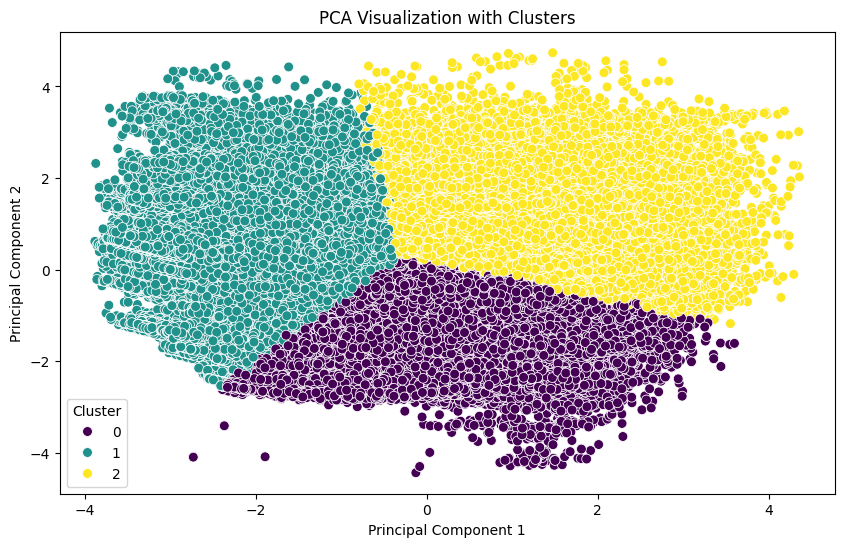

In [95]:
# Plot the PCA results with clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df_full, x='PCA1', y='PCA2', hue='Cluster', palette='viridis', s=50)
plt.title("PCA Visualization with Clusters")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()


In [112]:
# view cluster distribution across the entire dataset
pca_df_full.Cluster.value_counts(normalize=True)

,proportion
Cluster,
0,0.367524
2,0.346449
1,0.286027


In [97]:
# assign each observation to its respective cluster
full_df['Cluster'] = complete_labels

In [98]:
# inverse transform num features to ensure intuitive representation
full_df[numerical_columns]=Scaler.inverse_transform(full_df[numerical_columns])

In [99]:
full_df.head()

,Mileage_km,Power_HP,Displacement_cm3,Price_CAD,Years_From_Production_To_Offer,Type,Cluster
0,1.0,145.0,1400.0,28006.0,0.0,small_cars,1
2,52000.0,180.0,1368.0,14588.0,3.0,small_cars,1
3,29000.0,160.0,1368.0,12964.0,9.0,small_cars,1
4,600.0,165.0,1368.0,31808.0,0.0,small_cars,1
5,46060.0,180.0,1368.0,20452.0,5.0,small_cars,1


Calculating the mean and mode of each feature across the entire dataset, grouped by clusters, to compare them with the cluster centroids.

In [100]:
# Define a function to calculate mode for categorical columns
def mode(series):
    return series.mode()[0] if not series.mode().empty else None

# Separate numeric and categorical columns
numeric_cols = full_df.select_dtypes(include='number').columns
categorical_cols = full_df.select_dtypes(exclude='number').columns

# Aggregate data: mean for numeric, mode for categorical
aggregated_df = full_df.groupby('Cluster').agg({**{col: 'mean' for col in numeric_cols},
                                           **{col: mode for col in categorical_cols}})

# Reset index for better readability
#aggregated_df = aggregated_df.reset_index()

# Output
aggregated_df


,Mileage_km,Power_HP,Displacement_cm3,Price_CAD,Years_From_Production_To_Offer,Cluster,Type
Cluster,,,,,,,
0,150197.011901,95.577138,1401.309542,7091.687499,10.399889,0.0,city_cars
1,51889.588932,145.303125,1629.839559,26492.642266,2.889968,1.0,SUV
2,222996.854484,146.498103,1988.556916,8080.586875,12.867868,2.0,station_wagon


## 3.10. How can the Results be Leveraged?

Insurers can leverage insights from the identified clusters to optimize operations and customer engagement across three strategic areas: **fraud detection**, **tailored coverage**, and **targeted marketing**. Here’s a breakdown of the applications:

---

### 1. **Fraud Detection**

#### Objective:
Identify and mitigate fraudulent claims, ensuring cost savings and operational efficiency.

#### Strategy:
- **Cluster-Specific Risk Profiling:**  
  Historical data can be analyzed to identify patterns of fraudulent claims within each cluster. For instance:
  - **Older City Commuters:** Higher likelihood of exaggerated damage claims due to age and mileage-related issues.
  - **Modern Power Vehicles:** Potential for false theft claims given the high value of these vehicles.
  - **Seasoned Family Travelers:** Risk of fabricated mechanical failure claims due to extensive mileage.

- **Flagging Anomalies:**  
  - Claims from a vehicle that deviate from the historical data trends of its cluster (e.g., unusually frequent or expensive claims) can be flagged for deeper scrutiny.
  - Clusters with higher instances of fraud can be monitored more intensively.

#### Business Impact:
- Save costs by reducing payouts on fraudulent claims.  
- Lower the operational costs associated with scrutinizing claims, as only suspicious claims will require deeper investigation.  
- Maintain a fair claims process, ensuring genuine customers experience faster resolutions.


---

### 2. **Tailored Coverage**

#### Objective:
Reduce information asymmetry by offering coverage options that align with the risk profiles and needs of each cluster.

#### Strategy:
- **Risk-Based Premium Adjustments:**  
  - Use claims likelihood derived from cluster data to dynamically price premiums.  
    - **Older City Commuters:** Adjust premiums for high-mileage wear and tear risks.
    - **Modern Power Vehicles:** Offer specialized theft and feature protection plans.
    - **Seasoned Family Travelers:** Focus on comprehensive coverage for mechanical breakdowns.

- **Enhanced Underwriting Precision:**  
  Data-driven insights from the clusters help refine underwriting criteria, reducing exposure to adverse selection and moral hazard.

#### Business Impact:
- Optimize risk exposure while ensuring competitive pricing.
- Improve customer satisfaction by offering relevant and transparent policies.

---

### 3. **Targeted Marketing**

#### Objective:
Increase customer acquisition and retention by crafting appealing offers tailored to each cluster's preferences.

#### Strategy:
- **Cluster-Centric Campaigns:**  
  Design marketing campaigns that align with the values and priorities of each group:
  - **Older City Commuters:** Highlight affordability and basic maintenance perks.
  - **Modern Power Vehicles:** Emphasize comprehensive packages with high-value protection and roadside assistance.
  - **Seasoned Family Travelers:** Promote policies focusing on reliability and coverage for high-mileage vehicles.

- **Customer Education:**  
  Provide insights into the most common claims for vehicles in a customer’s cluster to build trust and demonstrate expertise.

#### Business Impact:
- Drive targeted lead generation, improving conversion rates.
- Enhance brand loyalty by addressing customer-specific concerns.

---

### In Closing

By strategically integrating cluster insights into fraud detection, tailored coverage, and targeted marketing, Insurers can:
- Mitigate financial risks associated with fraudulent claims.
- Deliver personalized, competitive coverage options to customers.
- Strengthen market position through focused, customer-centric campaigns.




## 3.11 Threats to Validity
The clustering process is exposed to sampling bias due to the random sampling of data. While the sample appears to be representative of the entire dataset, it is important to acknowledge this potential bias. Additionally, clustering evaluation, including the selection of the optimal number of clusters (K), is inherently subjective. There is no single metric that can fully assess clustering performance, so this introduces another threat to validity. Lastly, features were selected based on intuition and their potential business applications; however, it is possible that a different combination of features could provide further insights.

## 3.12. Next Steps

- Investigate and engineer more feature combinations to enhance the quality of clustering. This could involve creating new derived features or experimenting with different sets of existing features to uncover deeper insights.

- Try to increase the silhouette score to over 0.5 by fine-tuning the current feature set and exploring different clustering techniques.

- Experiment with other clustering algorithms, such as K-Means, DBSCAN, or Hierarchical Clustering, to compare their performance against the current K-Prototypes model. Assess which algorithm provides better cluster separation and insights.
- Apply NLP techniques to the features variable to identify common car features, discern which features are associated with each cluster, and highlight those that could be considered premium. Additionally, apply these techniques to the location column for spatial analysis.
- Given that the dataset contains many anomalies, these outliers are unlikely to fit well into any of the clusters. Outliers were even excluded from the data prior to training. Therefore, anomaly detection techniques could be applied to identify these anomalies and further investigate them to develop the best strategy for handling them.

